```
This notebook sets up barotropic drifters at the North Cape
Copyright (C) 2022 - 2023 SINTEF Digital
Copyright (C) 2022 - 2023 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 26b98e82e8d4e1ca2369cf735af8c7d3af460403 on branch reduced_gravity


# North Cape: Barotropic Drifters

This notebok shows the set-up, but for the simulation run `Barents-run_btdrift.py` and in the end of the notebook are postprocessing utils

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, Common, NetCDFInitialization, WindStress, OceanographicUtilities

from gpuocean.SWEsimulators import CDKLM16

In [4]:
%cuda_context_handler barotropic_gpu_ctx

Path to the test file

In [5]:
source_url = "/sintef/data/NorFjords160/A12/norfjords_160m_his.nc4_2020020101-2020020200"

## Inspecting file structure and content

In [6]:
from netCDF4 import Dataset
nc = Dataset(source_url)

In [7]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:      (ocean_time: 24, s_rho: 35, s_w: 36, eta_rho: 1271, xi_rho: 2051, eta_u: 1271, xi_u: 2050, eta_v: 1270, xi_v: 2051)
Coordinates:
  * ocean_time   (ocean_time) datetime64[ns] 2020-02-01T01:00:00 ... 2020-02-02
  * s_rho        (s_rho) float64 -0.9857 -0.9571 -0.9286 ... -0.04286 -0.01429
  * s_w          (s_w) float64 -1.0 -0.9714 -0.9429 ... -0.05714 -0.02857 0.0
    lon_rho      (eta_rho, xi_rho) float64 ...
    lat_rho      (eta_rho, xi_rho) float64 ...
    lon_u        (eta_u, xi_u) float64 ...
    lat_u        (eta_u, xi_u) float64 ...
    lon_v        (eta_v, xi_v) float64 ...
    lat_v        (eta_v, xi_v) float64 ...
Dimensions without coordinates: eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v
Data variables: (12/32)
    Vtransform   int32 ...
    Vstretching  int32 ...
    theta_s      float64 ...
    theta_b      float64 ...
    Tcline       float64 ...
    hc           float64 ...
    ...           ...
    u            (ocean_time, s_rho, eta_u, xi_u) float32 ...
    v            (ocean_time, s_rho, eta_v, xi_v) float32 ...
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    AKt          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    AKs          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
Attributes:
    history:      Created by roms2nc4single.py from ROMS output file
    institution:  Institute of Marine Research
    type:         ROMS/TOMS history file
    title:        ROMS 3.5 - NorFjords
    svn_url:      https://www.myroms.org/svn/omlab/branches/kate
    code_dir:     /cluster/work/users/jonal/NorROMS/ROMS_src/official/ROMS_kate
    CPP_options:  NORFJORDS, ALBEDO, ATM_PRESS, ANA_BSFLUX, ANA_BTFLUX, ANA_S...

Animation utils

In [8]:
import animation_utils

## Generating GPUOcean Simulation from Input

General parameters

In [9]:
dimY, dimX = ds.h.data.shape
x0, x1, y0, y1 = 1100, dimX-350, 315, dimY-585

Simulation span: 6h!

In [10]:
t_start = 9
t_stop =  t_start + 6

T = (t_stop-t_start)*3600  #Input
timestep_indices = [list(np.arange(t_start, t_stop+1))]

Generating wind fields

In [11]:
from gpuocean.utils import WindStress

def rotate_wind_field(wind, angle, plot=False):
    radians = (angle/360)*2*np.pi
    wind_u = wind.wind_u.copy()
    wind_v = wind.wind_v.copy()
    t = wind.t.copy()
    #print(t)

    c = np.cos(radians)
    s = np.sin(radians)
    wind_u_new = wind_u * c - wind_v * s
    wind_v_new = wind_u * s + wind_v * c

    if plot:
        x0, x1 = 200, 220
        y0, y1 = 200, 220

        fig = plt.figure()
        plt.quiver(wind_u[3, y0:y1, x0:x1], wind_v[3, y0:y1, x0:x1])

        fig = plt.figure()
        plt.quiver(wind_u_new[3, y0:y1, x0:x1], wind_v_new[3, y0:y1, x0:x1])
    return WindStress.WindStress(t=t, wind_u=wind_u_new, wind_v=wind_v_new)


### Initial conditions

In [12]:
ref_barotropic_data_args = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1, timestep_indices=timestep_indices, norkyst_data=False, land_value=0.0, download_data=False)

In [13]:
ref_barotropic_sim = CDKLM16.CDKLM16(barotropic_gpu_ctx, **NetCDFInitialization.removeMetadata(ref_barotropic_data_args), dt=0.0, write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [14]:
subt = 3600
for runt in range(int(T/subt)):
    ref_barotropic_sim.step(subt)


### Barotropic Drifters

Perturbations

In [15]:
ref_wind = ref_barotropic_data_args["wind"]

barotropic_wind_directions = np.arange(-20, 21, 5)
barotropic_wind_samples = [None]*len(barotropic_wind_directions)
print(barotropic_wind_directions)
for i in range(len(barotropic_wind_directions)):
    barotropic_wind_samples[i] = rotate_wind_field(ref_wind, barotropic_wind_directions[i])

[-20 -15 -10  -5   0   5  10  15  20]


In [16]:
max_shift_t = 9

time_shifted_data_args = []

for shift_t in range(-max_shift_t,max_shift_t):

    shifted_timestep_indices = [np.arange(t_start+shift_t, t_stop+shift_t+1)]
    time_shifted_data_args_i = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1, timestep_indices=shifted_timestep_indices, norkyst_data=False, land_value=5.0, download_data=False)

    time_shifted_data_args.append(time_shifted_data_args_i)

Creating simulators

In [17]:
import pandas as pd 

barotropic_sims = []
bt_table = pd.DataFrame(columns=["barotropic_id", "wind_rotation_id", "time_shift_id"]).set_index("barotropic_id")

for i_w in range(len(barotropic_wind_samples)):
    for i_t in range(2*max_shift_t):
        data_args = copy.copy(time_shifted_data_args[i_t])
        data_args["wind"] = barotropic_wind_samples[i_w]
        barotropic_sims.append( CDKLM16.CDKLM16(barotropic_gpu_ctx, **NetCDFInitialization.removeMetadata(data_args), dt=0.0) )

        bt_table.loc[len(bt_table)] = [i_w, i_t]

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

In [18]:
bt_table.head()

,wind_rotation_id,time_shift_id
barotropic_id,,
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


Creating drifters

In [19]:
windage_samples = np.arange(0.0, 0.051, 0.005)

In [20]:
import pandas as pd
ref_table = pd.DataFrame(columns=["drifter_id", "barotropic_id", "windage_id"]).set_index("drifter_id")

for bt in range(len(barotropic_sims)):
    for windage in range(len(windage_samples)):
        ref_table.loc[len(ref_table.index)] = [bt, windage]

In [21]:
ref_table.head()

,barotropic_id,windage_id
drifter_id,,
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


In [22]:
from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [23]:
observation_type = dautils.ObservationType.UnderlyingFlow 
    
observation_args = {'observation_type': observation_type,
                'nx': ref_barotropic_sim.nx, 'ny': ref_barotropic_sim.ny,
                'domain_size_x': ref_barotropic_sim.nx*ref_barotropic_sim.dx,
                'domain_size_y': ref_barotropic_sim.ny*ref_barotropic_sim.dy,
                'land_mask': ref_barotropic_sim.getLandMask()
                }

trajectories = Observation.Observation(**observation_args)

In [24]:
initx = [47500, 60000, 72500, 80000, 72500, 50000, 30000]
inity = [42500, 30500, 37500, 27500, 15000,  7500,  5000]

num_drifters = len(initx)

In [25]:
crossprod_trajectories = []
for cp in range(len(ref_table)):
    crossprod_trajectories.append(copy.deepcopy(trajectories))

In [26]:
barotropic_wind_samples[bt_table.iloc[ref_table.iloc[2].barotropic_id].wind_rotation_id]

In [27]:
crossprod_drifters = []
for cp in range(len(ref_table)):
    drifters = GPUDrifterCollection.GPUDrifterCollection(barotropic_gpu_ctx, # OBS: This is used for wind drift! 
                                                    num_drifters,
                                                    boundaryConditions = ref_barotropic_sim.boundary_conditions,
                                                    domain_size_x = trajectories.domain_size_x,
                                                    domain_size_y = trajectories.domain_size_y,
                                                    gpu_stream = ref_barotropic_sim.gpu_stream,
                                                    wind = barotropic_wind_samples[bt_table.iloc[ref_table.iloc[cp].barotropic_id].wind_rotation_id],
                                                    wind_drift_factor = windage_samples[ref_table.iloc[cp].windage_id])          

    drifter_pos_init = np.array([initx, inity]).T
    drifters.setDrifterPositions(drifter_pos_init)
    crossprod_drifters.append(drifters)

In [28]:
from itertools import compress

for bt in range(len(barotropic_sims)):
    barotropic_sims[bt].attachCrossProductDrifters( 
        list(compress(crossprod_drifters, ref_table["barotropic_id"] == bt)), 
        int(np.sum(ref_table["barotropic_id"] == bt))* [None] )

In [29]:
for d in range(len(crossprod_drifters)):
    crossprod_trajectories[d].add_observation_from_drifters(crossprod_drifters[d], 0.0)

In [30]:
for bt in range(len(barotropic_sims)):
    print(bt)
    drifter_ids = ref_table.index[ref_table["barotropic_id"]==bt].tolist()
    while barotropic_sims[bt].t < T:
        barotropic_sims[bt].step(360)
        for d in drifter_ids:
            crossprod_trajectories[d].add_observation_from_drifters(crossprod_drifters[d], barotropic_sims[bt].t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161


In [31]:
os.makedirs("barents_pickles", exist_ok=True)
for cp in range(len(crossprod_trajectories)):
    crossprod_trajectories[cp].to_pickle("barents_pickles/bt_trajectory"+str(cp))


In [32]:
STOP

Exception caught: Resetting to CUDA context barotropic_gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2302038/2165152129.py", line 1, in <module>
    STOP
NameError: name 'STOP' is not defined


NameError: name 'STOP' is not defined

## Post-Processing

In [22]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [23]:
source_url = "/sintef/data/NorFjords160/A12/norfjords_160m_his.nc4_2020020101-2020020200"

In [24]:
from netCDF4 import Dataset
nc = Dataset(source_url)

In [25]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:      (ocean_time: 24, s_rho: 35, s_w: 36, eta_rho: 1271, xi_rho: 2051, eta_u: 1271, xi_u: 2050, eta_v: 1270, xi_v: 2051)
Coordinates:
  * ocean_time   (ocean_time) datetime64[ns] 2020-02-01T01:00:00 ... 2020-02-02
  * s_rho        (s_rho) float64 -0.9857 -0.9571 -0.9286 ... -0.04286 -0.01429
  * s_w          (s_w) float64 -1.0 -0.9714 -0.9429 ... -0.05714 -0.02857 0.0
    lon_rho      (eta_rho, xi_rho) float64 ...
    lat_rho      (eta_rho, xi_rho) float64 ...
    lon_u        (eta_u, xi_u) float64 ...
    lat_u        (eta_u, xi_u) float64 ...
    lon_v        (eta_v, xi_v) float64 ...
    lat_v        (eta_v, xi_v) float64 ...
Dimensions without coordinates: eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v
Data variables: (12/32)
    Vtransform   int32 ...
    Vstretching  int32 ...
    theta_s      float64 ...
    theta_b      float64 ...
    Tcline       float64 ...
    hc           float64 ...
    ...           ...
    u            (ocean_time, s_rho, eta_u, xi_u) float32 ...
    v            (ocean_time, s_rho, eta_v, xi_v) float32 ...
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    AKt          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    AKs          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
Attributes:
    history:      Created by roms2nc4single.py from ROMS output file
    institution:  Institute of Marine Research
    type:         ROMS/TOMS history file
    title:        ROMS 3.5 - NorFjords
    svn_url:      https://www.myroms.org/svn/omlab/branches/kate
    code_dir:     /cluster/work/users/jonal/NorROMS/ROMS_src/official/ROMS_kate
    CPP_options:  NORFJORDS, ALBEDO, ATM_PRESS, ANA_BSFLUX, ANA_BTFLUX, ANA_S...

In [26]:
dimY, dimX = ds.h.data.shape
x0, x1, y0, y1 = 1100, dimX-350, 315, dimY-585

In [27]:
nx = (x1-x0)
ny = (y1-y0)
dx, dy = 160.0, 160.0

In [28]:
t_start = 9

Import saved results

In [29]:
from gpuocean.utils import Observation

In [62]:
timestamp = None
timestamp = "2023-04-12T09_50_29" 

In [63]:
crossprod_trajectories = []

if timestamp is None:
    for f in os.listdir('barents_pickles/'):
        if f.startswith("bt_trajectory"):
            obs= Observation.Observation()
            obs.read_pickle('barents_pickles/'+ f )
            crossprod_trajectories.append( obs )
else:
    for f in os.listdir('barents_pickles/'+timestamp):
        if f.startswith("bt_trajectory"):
            obs= Observation.Observation()
            obs.read_pickle('barents_pickles/'+timestamp+'/'+f )
            crossprod_trajectories.append( obs )

In [64]:
len(crossprod_trajectories)

300

In [65]:
with open("barents_figs/"+timestamp+"/log.txt") as f:
    print(f.readlines())

['Barotropic simulations:\n', 'init (time shifted): -9, -6, -3, 0, 3, 6\n', 'wind: 11.775896484360986, -2.668483153244585, -21.68187200525333, 26.225940860373175, -17.692538588039906\n', '\n', 'Drifter advection:\n', 'windage: 0.002147286398999401, 0.011000433311231086, 0.038656367406742775, 0.03222741925785934, 0.011409460111856687, 0.012088218630074993, 0.0, 0.022719932382468878, 0.04423949869886119, 0.037011236678632396\n']


In [51]:
num_drifters = crossprod_trajectories[0].get_num_drifters()
num_drifters

7

In [52]:
initx = crossprod_trajectories[0].obs_df["drifter_positions"][0][:,0]
inity = crossprod_trajectories[0].obs_df["drifter_positions"][0][:,1]

Generate OpenDrift trajectories

In [53]:
from opendrift.readers import reader_netCDF_CF_generic, reader_ROMS_native
from opendrift.models.oceandrift import OceanDrift

In [54]:
reader = reader_ROMS_native.Reader(source_url)
reader.start_time

No proj string or projection could be derived, using 'fakeproj'. This assumes that the variables are structured and gridded approximately equidistantly on the surface (i.e. in meters). This must be guaranteed by the user. You can get rid of this warning by suppling a valid projection to the reader.


datetime.datetime(2020, 2, 1, 1, 0)

In [55]:
init_local_index_x = np.array(initx)/dx
init_local_index_y = np.array(inity)/dy

init_global_index_x = init_local_index_x + x0
init_global_index_y = init_local_index_y + y0

init_lon, init_lat = reader.xy2lonlat(init_global_index_x, init_global_index_y)

In [56]:
def opendrift_trajectories(wind_drift_factor=0.0):
    o = OceanDrift(loglevel=20)
    o.add_reader(reader)

    o.seed_elements(lat=init_lat, lon=init_lon, time=reader.start_time+ datetime.timedelta(hours=t_start), 
                    wind_drift_factor=wind_drift_factor*np.ones_like(init_lat))

    o.run(duration = datetime.timedelta(hours=6), time_step=600, time_step_output=600)

    ts = o.get_time_array()[1]
    for i in range(len(ts)):
        ts[i] = ts[i].total_seconds()
    ts = np.array(ts)

    lon, lat = o.get_lonlats()
    x,y = reader.lonlat2xy(lon,lat)

    X = (x-x0)*dx
    Y = (y-y0)*dy

    trajectories = Observation.Observation(domain_size_x=nx*dx, domain_size_y=ny*dy, nx=x1-x0, ny=y1-y0, land_mask=1-nc["mask_rho"][y0:y1,x0:x1])
    trajectories.add_observations_from_arrays(ts, X, Y)

    return trajectories

In [57]:
o_wind_drift_factors = [0.0, 0.015, 0.03]

In [58]:
o_trajectories = [opendrift_trajectories(wind_drift_factor) for wind_drift_factor in o_wind_drift_factors]

09:54:00 INFO    opendrift.models.basemodel: OpenDriftSimulation initialised (version 1.8.5)
09:54:00 INFO    opendrift.models.basemodel: Fallback values will be used for the following variables which have no readers: 
09:54:00 INFO    opendrift.models.basemodel: 	upward_sea_water_velocity: 0.000000
09:54:00 INFO    opendrift.models.basemodel: 	sea_surface_wave_significant_height: 0.000000
09:54:00 INFO    opendrift.models.basemodel: 	sea_surface_wave_stokes_drift_x_velocity: 0.000000
09:54:00 INFO    opendrift.models.basemodel: 	sea_surface_wave_stokes_drift_y_velocity: 0.000000
09:54:00 INFO    opendrift.models.basemodel: 	sea_surface_wave_period_at_variance_spectral_density_maximum: 0.000000
09:54:00 INFO    opendrift.models.basemodel: 	sea_surface_wave_mean_period_from_variance_spectral_density_second_frequency_moment: 0.000000
09:54:00 INFO    opendrift.models.basemodel: 	surface_downward_x_stress: 0.000000
09:54:00 INFO    opendrift.models.basemodel: 	surface_downward_y_stress: 0

In [61]:
def plot_cp_trajectories(crossprod_trajectories, o_trajectories, drifter_id):
    with plt.rc_context({'lines.color':'black', 
                            'text.color':'black', 
                            'axes.labelcolor':'black', 
                            'xtick.color':'black',
                            'ytick.color':'black'}):
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        ax.tick_params(axis='both', which='major', labelsize=28)

        domain_extent = [0, (x1-x0)*160.0/1000, 
                         0, (y1-y0)*160.0/1000]

        bg_cmap = copy.deepcopy(plt.cm.Blues)
        bg_cmap.set_bad("grey", alpha = 1.0)

        ax.imshow(np.ma.array(nc["mask_rho"][y0:y1, x0:x1], mask=(1-nc["mask_rho"][y0:y1, x0:x1])), interpolation="none", origin='lower', 
                        cmap=bg_cmap, extent=domain_extent, zorder=-10)
        

        try:
            lat = np.array(nc.variables["lat_rho"])
            lon = np.array(nc.variables["lon_rho"])

            spec_lat = lat[y0:y1, x0:x1]
            spec_lon = lon[y0:y1, x0:x1]

            cont_lon_case = ax.contour(spec_lon, levels = np.arange(20, 30, 0.5), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
            cont_lat_case = ax.contour(spec_lat, levels = np.arange(70, 72, 0.5), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

        except Exception as e:
            raise e


        T = crossprod_trajectories[0].obs_df.iloc[-1].time
        dummy_path = crossprod_trajectories[0].get_drifter_path(drifter_id, 0,  T, in_km = True)[0]
        start_pos = dummy_path[0,:]
        circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                0.01, color = 'black', fill=True, zorder=2)
        ax.add_patch(circ_start)      

        # Save paths to array
        num_results = len(crossprod_trajectories)
        X = np.zeros((dummy_path.shape[0], num_results))
        Y = np.zeros((dummy_path.shape[0], num_results))
        
        counter=0
        for path in [t.get_drifter_path(drifter_id, 0, T, in_km = True)[0] for t in crossprod_trajectories]:
            try:
                X[:,counter] = np.minimum(np.maximum(0, path[:,0]), (x1-x0)*160.0/1000)
                Y[:,counter] = np.minimum(np.maximum(0, path[:,1]), (y1-y0)*160.0/1000)
                counter+=1
            except:
                pass
            

        # Plot paths from array
        ax.plot(X, Y, color="C0", ls="-", zorder=-3, alpha=0.05) #, rasterized=True)
        ax.scatter(X[-1,:], Y[-1, :], marker='x', color='black', s=2, linewidths=2, zorder=-4)# , rasterized=True)


        # Plot opendrift paths
        for opath in [ot.get_drifter_path(drifter_id, 0, T, in_km = True)[0] for ot in o_trajectories]:
            ax.plot(opath[:,0], opath[:,1], color="C1", ls="-", zorder=1)


        plt.tight_layout()
        if timestamp is None:
            os.makedirs("barents_figs", exist_ok=True)
            plt.savefig("barents_figs/BTdrift"+str(drifter_id)+".pdf", bbox_inches="tight", dpi=400)

            ax.set_rasterization_zorder(0)
            plt.savefig("barents_figs/BTdrift"+str(drifter_id)+"_rasterised.pdf", bbox_inches="tight", dpi=400)
        else:
            plt.savefig("barents_figs/"+timestamp+"/BTdrift"+str(drifter_id)+".pdf", bbox_inches="tight", dpi=400)

            ax.set_rasterization_zorder(0)
            plt.savefig("barents_figs/"+timestamp+"/BTdrift"+str(drifter_id)+"_rasterised.pdf", bbox_inches="tight", dpi=400)

            # ax.plot(path[:,0], path[:,1], color="C0", ls="-", zorder=5, alpha=0.05)
            
            # end_pos = path[-1,:]
            # ax.scatter(end_pos[0], end_pos[1], marker='x', color='black', s=2, linewidths=1, alpha=0.5, zorder=6)



        # ax.plot(((np.array(opendrift_results["x"][0] ) - x0)*50.0)/1000, ((np.array(opendrift_results["y"][0] ) - y0)*50.0)/1000, c="red")


        
        


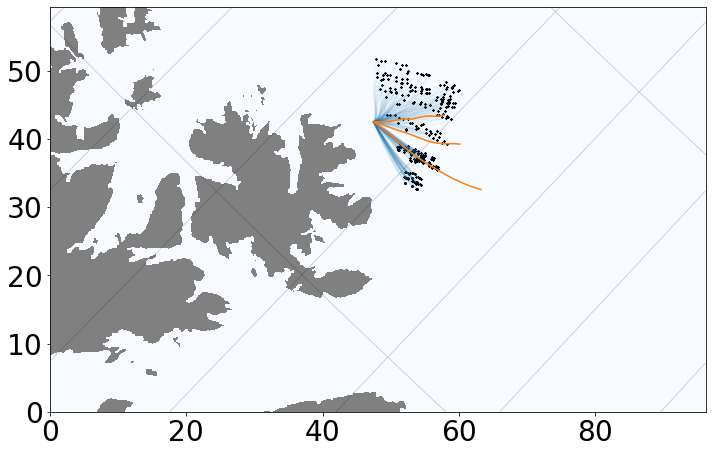

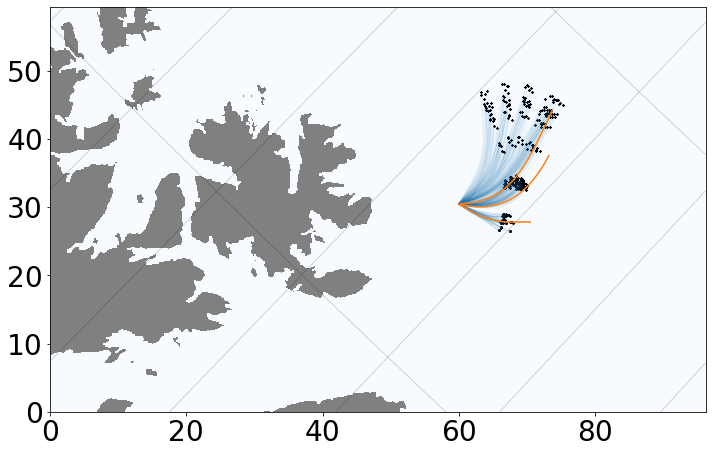

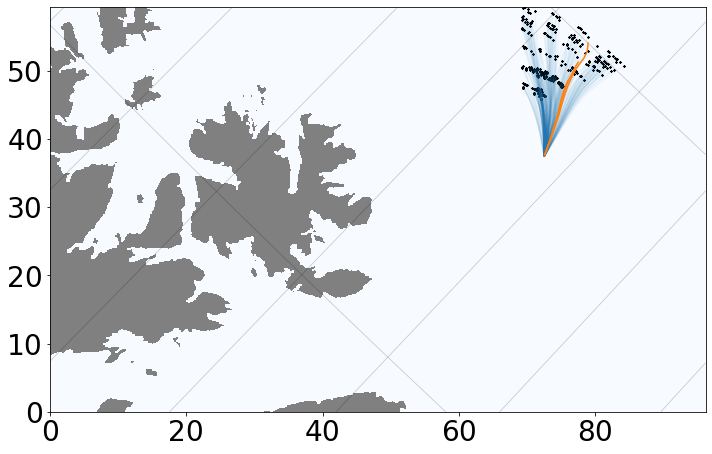

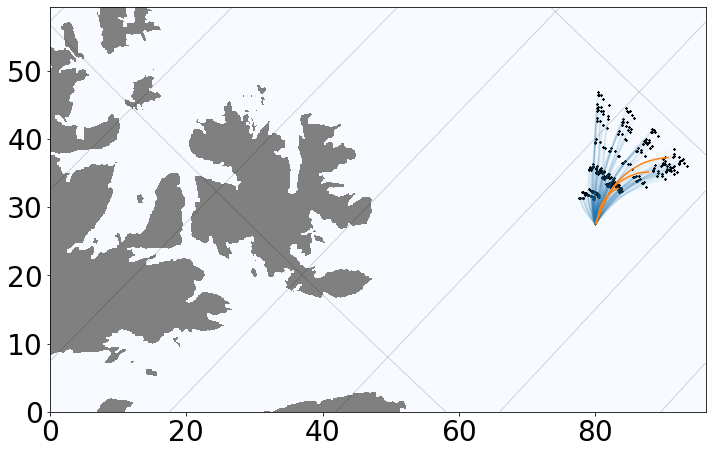

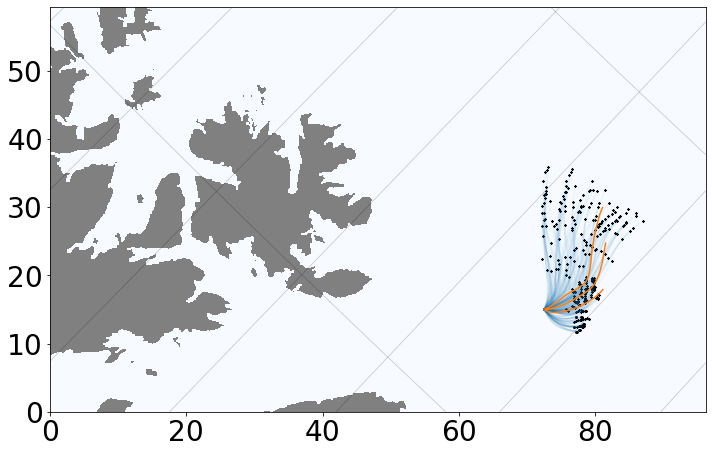

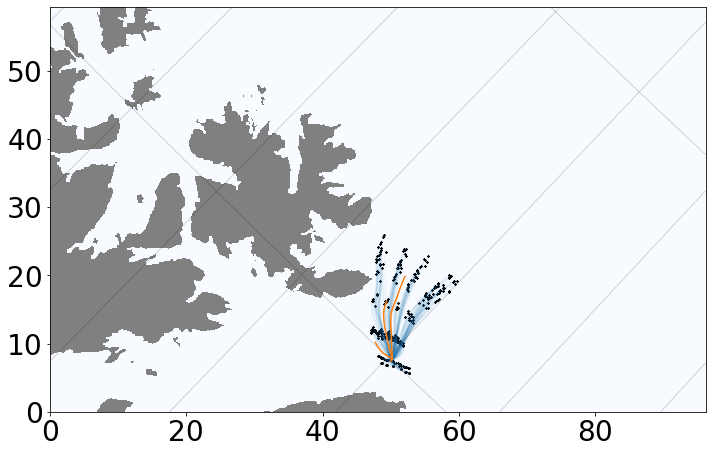

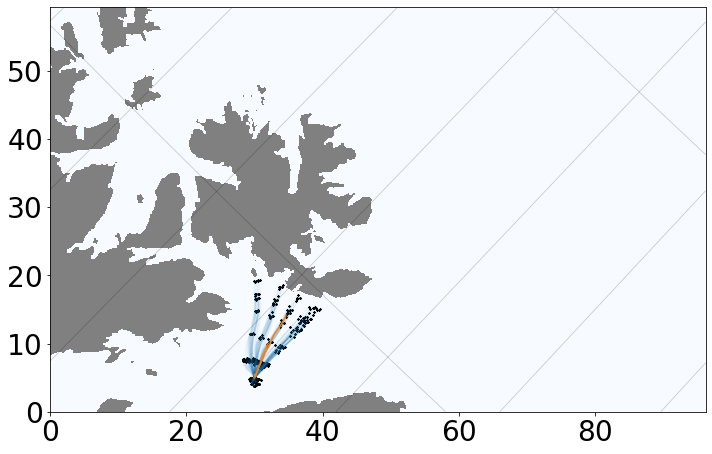

In [66]:
for drifter_id in range(num_drifters):
    plot_cp_trajectories(crossprod_trajectories, o_trajectories, drifter_id)

In [ ]:
def plot_cp_kde(drifter_id, trajectories, o_trajectories):

    # Space and time 
    nx = (x1-x0)
    ny = (y1-y0)

    dx = 50.0
    dy = 50.0

    T = trajectories[0].obs_df.iloc[-1].time

    ## Get last postions
    numTrajectories = len(trajectories)

    last_positions = np.zeros((numTrajectories,2))
    for d in range(numTrajectories):
        last_positions[d] = trajectories[d].get_drifter_path(drifter_id, 0, T)[-1][-1]

    # Axes
    x = np.arange(nx)*dx
    y = np.arange(ny)*dy
    x/=1000
    y/=1000
    xx, yy = np.meshgrid(x,y)
    ccs = np.vstack([xx.ravel(), yy.ravel()])

    ## Kernel density estimation 
    clp = (last_positions-np.average(last_positions,axis=0)).T
    clp[0][clp[0] > (x[-1]/2)] = clp[0][clp[0] > (x[-1]/2)] - x[-1]
    clp[0][clp[0] < (-x[-1]/2)] = clp[0][clp[0] < (-x[-1]/2)] + x[-1]
    clp[1][clp[1] > (y[-1]/2)] = clp[1][clp[1] > (y[-1]/2)] - y[-1]
    clp[1][clp[1] < (-y[-1]/2)] = clp[1][clp[1] < (-y[-1]/2)] + y[-1]

    raw_cov = np.cov(clp)

    bw = 100**(-1./(2+4)) #* 0.5 #for whtatever reason scipy.stats.gaussian_kde is roughly half of that

    cov = raw_cov * bw
    covinv = np.linalg.inv(cov)

    f = np.ma.array(np.zeros((ny,nx)), mask=1-nc["mask_rho"][y0:y1,x0:x1])

    sea_mask = np.array(nc["mask_rho"][y0:y1,x0:x1], dtype=bool)
    for e in range(numTrajectories):
        d = (ccs.T-last_positions[e]).T
        d[0][d[0] > (x[-1]/2)] = d[0][d[0] > (x[-1]/2)] - x[-1]
        d[0][d[0] < (-x[-1]/2)] = d[0][d[0] < (-x[-1]/2)] + x[-1]
        d[1][d[1] > (y[-1]/2)] = d[1][d[1] > (y[-1]/2)] - y[-1]
        d[1][d[1] < (-y[-1]/2)] = d[1][d[1] < (-y[-1]/2)] + y[-1]
        temp_f = np.exp(-1/2*np.sum((d*np.dot(covinv,d)), axis=0)).reshape(ny,nx)
        temp_mass = np.sum(temp_f)
        temp_sea_mass = np.sum(temp_f[sea_mask])
        f += temp_mass/temp_sea_mass * temp_f
        
    ## Levels for plotting
    fmass = np.sum(f)

    fmax = np.max(f)
    levels = np.linspace(0,fmax,100)
    level_probs = np.zeros(100)
    for l in range(len(levels)):
        level_probs[l] = np.sum(f[f>levels[l]])/fmass
    level_probs[-1] = 0.0

    desired_probs = [0.9,0.75,0.5,0.25,0.0] #descending! (ending with 0.0)
    desired_levels = np.zeros_like(desired_probs)
    for p in range(len(desired_probs)):
        desired_levels[p] = levels[np.abs(level_probs-desired_probs[p]).argmin()]
    desired_levels = np.unique(desired_levels)

    with plt.rc_context({'lines.color':'black', 
                            'text.color':'black', 
                            'axes.labelcolor':'black', 
                            'xtick.color':'black',
                            'ytick.color':'black'}):
        ## Contour plots
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        ax.tick_params(axis='both', which='major', labelsize=28)

        domain_extent = [0, nx*dx/1000, 0, ny*dy/1000]

        bg_cmap = copy.deepcopy(plt.cm.Blues)
        bg_cmap.set_bad("grey", alpha = 1.0)

        ax.imshow(np.ma.array(nc["mask_rho"][y0:y1, x0:x1], mask=(1-nc["mask_rho"][y0:y1, x0:x1])), interpolation="none", origin='lower', 
                        cmap=bg_cmap, extent=domain_extent, zorder=2)

        cfset = ax.contourf(xx, yy, f, levels=desired_levels, cmap='Greens', alpha=0.5, zorder=3)
        cset = ax.contour(xx, yy, f, levels=desired_levels, colors='k', alpha=0.25, linewidths=1, zorder=4)

        try:
            lat = np.array(nc.variables["lat_rho"])
            lon = np.array(nc.variables["lon_rho"])

            spec_lat = lat[y0:y1, x0:x1]
            spec_lon = lon[y0:y1, x0:x1]

            cont_lon_case = ax.contour(spec_lon, levels = np.arange(10, 12, 0.1), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
            cont_lat_case = ax.contour(spec_lat, levels = np.arange(58, 62, 0.1), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

        except Exception as e:
            raise e

        proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cfset.collections]
        labels = []
        for p in desired_probs:
            labels.append(str(int(p*100))+"%")
        ax.legend(proxy, labels, prop={'size': 26}, labelcolor="black", loc=4, framealpha=0.9)


        # Plot opendrift paths
        if o_trajectories is not None:
            dummy_path = o_trajectories[0].get_drifter_path(drifter_id, 0,  T, in_km = True)[0]
            start_pos = dummy_path[0,:]
            circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                    0.01, color = 'black', fill=True, zorder=2)
            ax.add_patch(circ_start)      
            for opath in [ot.get_drifter_path(drifter_id, 0, T, in_km = True)[0] for ot in o_trajectories]:
                ax.plot(opath[:,0], opath[:,1], color="C1", ls="-", zorder=1)


        plt.savefig("barents_figs/BTkde"+str(drifter_id)+".pdf", bbox_inches="tight")


In [ ]:
plot_cp_kde(0, trajectories, o_trajectories)

NameError: name 'plot_cp_kde' is not defined